In [1]:
%matplotlib_svg
%load_ext cython
import numpy as np
import pylab as pl

## 高效处理数组

### Cython的内存视图

In [2]:
%%cython
import numpy as np

cdef double buf[3][4]            #❶
cdef double[:, ::1] view = buf   #❷

def fill_value(double value):    
    np.asarray(view).fill(value) #❸

def sum_view():
    return np.sum(view)          #❹    
    
def get_view():
    return view                  #❺

def square_view():               #❻
    cdef int i, j
    for i in range(view.shape[0]):
        for j in range(view.shape[1]):
            view[i, j] *= view[i, j]

In [3]:
view = get_view()
%C view.shape; view.strides; view.itemsize; view.nbytes

view.shape  view.strides  view.itemsize  view.nbytes
----------  ------------  -------------  -----------
(3, 4)      (32, 8)       8              96         


In [4]:
fill_value(3.0)
print((sum_view()))
square_view()
print((sum_view()))
view[1, 2] = 10
print((sum_view()))

36.0
108.0
109.0


In [5]:
arr = np.asarray(view)
arr[1, 0] = 11
print((sum_view()))
print(arr)

111.0
[[  9.   9.   9.   9.]
 [ 11.   9.  10.   9.]
 [  9.   9.   9.   9.]]


In [7]:
print((view.base.__class__))
print((view.base.memview))

<type '_cython_magic_1118ba0f43c15a1b4a16015476c9c6fa.array'>
<MemoryView of 'array' object>


In [9]:
%%cython -a
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def square(double[:] x): #❶
    cdef int i
    cdef double[::1] res = np.empty_like(x)
    for i in range(x.shape[0]):
        res[i] = x[i] * x[i] #❷
    return res.base #❸

> **TIP**

> 在这个例子中我们通过第一个的注释`#cython: ...`设置`boundscheck`和`wraparound`编译选项。

In [11]:
%%cython
#cython: boundscheck=False, wraparound=False
import numpy as np
import cython

cpdef norm(double[:] x):
    cdef double s
    cdef int i
    s = 0
    for i in range(x.shape[0]):
        s += x[i]*x[i]
    s = 1 / s**0.5
    for i in range(x.shape[0]):
        x[i] *= s 

def norm_axis(double[:, :] x, int axis=0, bint inplace=True):
    cdef int i
    cdef double[:, :] data
    if not inplace:
        data = np.empty_like(x)
        data[:] = x #❶
    else:
        data = x
        
    if axis == 1:
        for i in range(data.shape[0]):
            norm(data[i, :]) #❷
    elif axis == 0:
        for i in range(data.shape[1]):
            norm(data[:, i])
            
    return data.base

In [12]:
%%cython
from libc.string cimport memcpy #❶

def copy_memview(double[::1] src, double[::1] dst):
    memcpy(&dst[0], &src[0], sizeof(double)*dst.shape[0]) #❷

In [13]:
a = np.random.rand(10)
b = np.zeros_like(a)
copy_memview(a, b)
assert np.all(a == b)

### 用降采样提高绘图速度

In [22]:
import numpy as np

def make_noise_sin_wave(period, n):
    np.random.seed(42)

    x = np.random.uniform(0, 2*np.pi*period, n)
    x.sort()
    y = np.sin(x)
    m = int(n*0.01)
    y[np.random.randint(0, n, m)] += np.random.randn(m) * 0.4
    return x, y

x, y = make_noise_sin_wave(10, 10000)

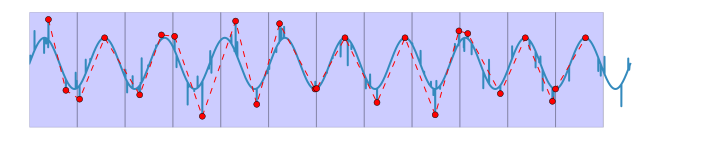

In [23]:
#%hide
#%fig=降低取样频率示意图
fig, ax = pl.subplots(figsize=(12, 2))
peak_index = []
for x0, x1 in zip(list(range(0, 60, 5)), list(range(5, 65, 5))):
    pl.axvspan(x0, x1, alpha=0.2)
    idx0 = np.searchsorted(x, x0)
    idx1 = np.searchsorted(x, x1)
    min_idx = np.argmin(y[idx0:idx1]) + idx0
    max_idx = np.argmax(y[idx0:idx1]) + idx0
    peak_index.extend([min_idx, max_idx])
peak_index.sort()
ax.plot(x, y)
ax.plot(x[peak_index], y[peak_index], "--ro", lw=1)
ax.axis("off");

In [17]:
def get_peaks_py(x, y, n, x0=None, x1=None):
    if x0 is None:
        x0 = x[0]
    if x1 is None:
        x1 = x[-1]
    index0, index1 = np.searchsorted(x, [x0, x1])
    index1 = min(index1, len(x) - 1)
    x0, x1 = x[index0], x[index1]
    dx = (x1 - x0) / n

    i = index0
    x_min = x_max = x[i]
    y_min = y_max = y[i]
    x_next = x0 + dx

    xr, yr = np.empty(2 * n), np.empty(2 * n)
    j = 0

    while True:
        xc, yc = x[i], y[i]
        if xc >= x_next or i == index1:
            if x_min > x_max:
                x_min, x_max = x_max, x_min
                y_min, y_max = y_max, y_min
            xr[j], xr[j + 1] = x_min, x_max
            yr[j], yr[j + 1] = y_min, y_max
            j += 2

            x_min = x_max = xc
            y_min = y_max = yc
            x_next += dx
            if i == index1:
                break
        else:
            if y_min > yc:
                x_min, y_min = xc, yc
            elif y_max < yc:
                x_max, y_max = xc, yc
        i += 1

    return xr[:j], yr[:j]

xr, yr = get_peaks_py(x, y, 200)

In [16]:
%%cython
import numpy as np
import cython

@cython.wraparound(False)  # ❶
@cython.boundscheck(False)
def get_peaks(double[::1] x, double[::1] y, int n, x0=None, x1=None):
    cdef int i, j, index0, index1
    cdef double x_min, x_max, y_min, y_max, xc, yc, x_next, dx
    cdef double[::1] xr, yr

    if x0 is None:
        x0 = x[0]
    if x1 is None:
        x1 = x[len(x) - 1]  # ❷

    index0, index1 = np.searchsorted(x, [x0, x1])  # ❸
    index1 = min(index1, len(x) - 1)
    x0, x1 = x[index0], x[index1]
    dx = (x1 - x0) / n

    i = index0
    x_min = x_max = x[i]
    y_min = y_max = y[i]
    x_next = x0 + dx

    xr = np.empty(2 * n)
    yr = np.empty(2 * n)
    j = 0

    while True:
        xc, yc = x[i], y[i]
        if xc >= x_next or i == index1:
            if x_min > x_max:
                x_min, x_max = x_max, x_min
                y_min, y_max = y_max, y_min
            xr[j], xr[j + 1] = x_min, x_max
            yr[j], yr[j + 1] = y_min, y_max
            j += 2

            x_min = x_max = xc
            y_min = y_max = yc
            x_next += dx
            if i == index1:
                break
        else:
            if y_min > yc:
                x_min, y_min = xc, yc
            elif y_max < yc:
                x_max, y_max = xc, yc
        i += 1

    return xr.base[:j], yr.base[:j] #❹

In [18]:
xr, yr = get_peaks_py(x, y, 200)
xr2, yr2 = get_peaks(x, y, 200)
print np.allclose(xr, xr2), np.allclose(yr, yr2)

%timeit get_peaks_py(x, y, 200)
%timeit get_peaks(x, y, 200)

True True
100 loops, best of 3: 9.55 ms per loop
10000 loops, best of 3: 78.7 µs per loop


> **SOURCE**

> `scpy2.cython.fast_curve_draw`演示使用降采样提高matplotlib的曲线绘制速度。降采样函数为`scpy2.cython.get_peaks()`。

In [25]:
#%hide
%exec_python -m scpy2.cython.fast_curve_draw